# Simple Neural Network Model with different outputs

Input: single principal component based on all 15 indicators 

Output: optimal max-shape portfolio with various constraint options for the next period

## Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.regularizers import L2

from helper_functions import train_and_evaluate_model
from cvxpy.error import SolverError

In [3]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider
from PortfolioOptimizer import PortfolioOptimizer

In [4]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()
days_to_recalculate = data_provider.get_days_to_recalculate()

In [5]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators)
    x.append(indicators.values)

x = np.array(x)
x.shape

(288, 6, 27)

In [6]:
val_split = int(0.7 * x.shape[0])
test_split = int(0.8 * x.shape[0])

# Train
dates_for_training = days_to_recalculate[:val_split]
x_train = x[:val_split]

# Validation
dates_for_validation = days_to_recalculate[val_split:test_split]
x_val = x[val_split:test_split]

# Test
dates_for_test = days_to_recalculate[test_split:]
x_test = x[test_split:]

## Defining models for different outputs

Tight constraints for weights between 0.7 * benchmark_weight and 1.5 * benchmark_weights

In [7]:
y = []
for i in range(0, len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_tight_constraints(acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except SolverError:
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / \
            summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
        print('Cannot get optimal portfolio for', days_to_recalculate[i])

    y.append(optimal_portfolio.values)

y_tight_constraints = np.array(y)

y_train_tight_constraints = y_tight_constraints[:val_split]
y_val_tight_constraints = y_tight_constraints[val_split:test_split]
y_test_tight_constraints = y_tight_constraints[test_split:]

Cannot get optimal portfolio for 2022-05-06 00:00:00
Cannot get optimal portfolio for 2022-08-03 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cannot get optimal portfolio for 2023-03-03 00:00:00
Cannot get optimal portfolio for 2023-05-04 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8328 - val_loss: 2.5951 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5195 - val_loss: 2.3015 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2336 - val_loss: 2.0361 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9751 - val_loss: 1.7975 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7430 - val_loss: 1.5843 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5354 - val_loss: 1.3941 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3505 - val_loss: 1.2251 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1859 - val_loss: 1.0751 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0403 - val_loss: 0.9421 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

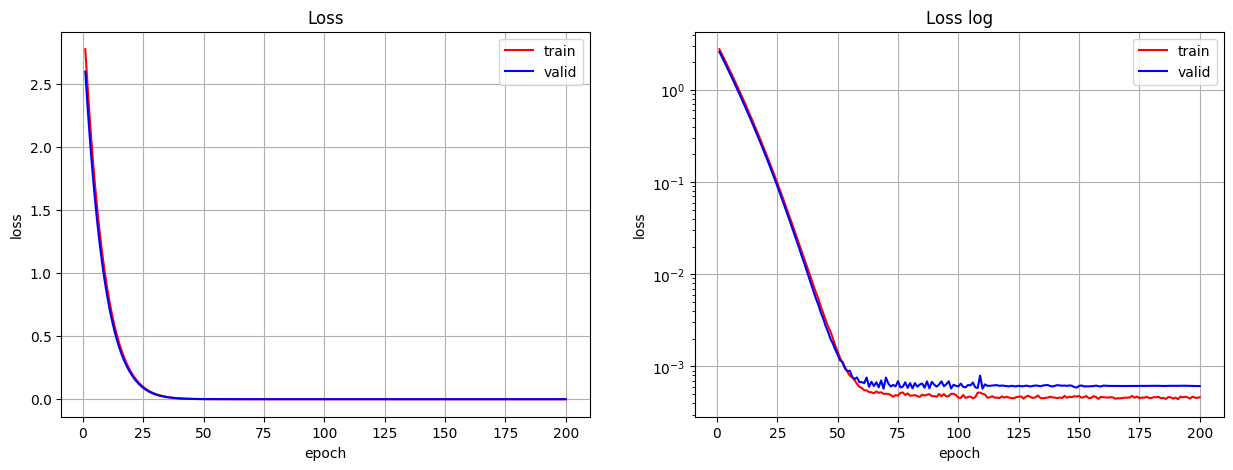

In [8]:
model_dnn_tight_constraints = Sequential((
    Flatten(input_shape=x_train.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train_tight_constraints.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_tight_constraints, 
                         x_train, y_train_tight_constraints,
                         x_val, y_val_tight_constraints, 
                         x_test, y_test_tight_constraints)

Normal constraints for weights between 0.5 * benchmark_weight and 2 * benchmark_weights

In [9]:
y = []
for i in range(0, len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    optimizer = PortfolioOptimizer()
    w, constraints = optimizer.get_normal_constraints(acwi_weights_year)
    optimal_portfolio = optimizer.get_optimal_portfolio(
        data_period, w, constraints)
    y.append(optimal_portfolio.values)

y_normal_constraints = np.array(y)

y_train_normal_constraints = y_normal_constraints[:val_split]
y_val_normal_constraints = y_normal_constraints[val_split:test_split]
y_test_normal_constraints = y_normal_constraints[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8804 - val_loss: 2.6381 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5630 - val_loss: 2.3413 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2727 - val_loss: 2.0718 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0091 - val_loss: 1.8289 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7720 - val_loss: 1.6109 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5599 - val_loss: 1.4163 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3709 - val_loss: 1.2430 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2020 - val_loss: 1.0890 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0529 - val_loss: 0.9526 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

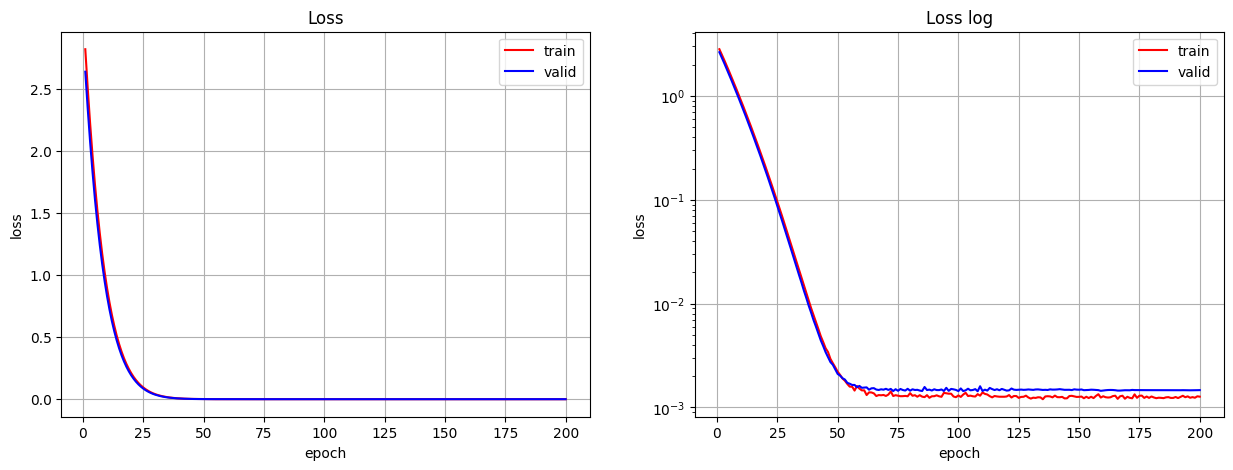

In [10]:
model_dnn_normal_constraints = Sequential((
    Flatten(input_shape=x_train.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train_normal_constraints.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_normal_constraints, 
                         x_train, y_train_normal_constraints,
                         x_val, y_val_normal_constraints, 
                         x_test, y_test_normal_constraints)

Loose constraints for weights between 0.3 * benchmark_weight and 3 * benchmark_weights

In [11]:
y = []
for i in range(0, len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_loose_constraints(acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except:        
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
        print('Cannot get optimal portfolio for', days_to_recalculate[i])
        
    y.append(optimal_portfolio.values)

y_loose_constraints = np.array(y)

y_train_loose_constraints = y_loose_constraints[:val_split]
y_val_loose_constraints = y_loose_constraints[val_split:test_split]
y_test_loose_constraints = y_loose_constraints[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [12]:
y_train_loose_constraints.shape

(201, 27)

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8281 - val_loss: 2.5888 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5161 - val_loss: 2.2977 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2313 - val_loss: 2.0338 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9736 - val_loss: 1.7960 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7419 - val_loss: 1.5829 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5340 - val_loss: 1.3925 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3487 - val_loss: 1.2231 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1844 - val_loss: 1.0726 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0378 - val_loss: 0.9392 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

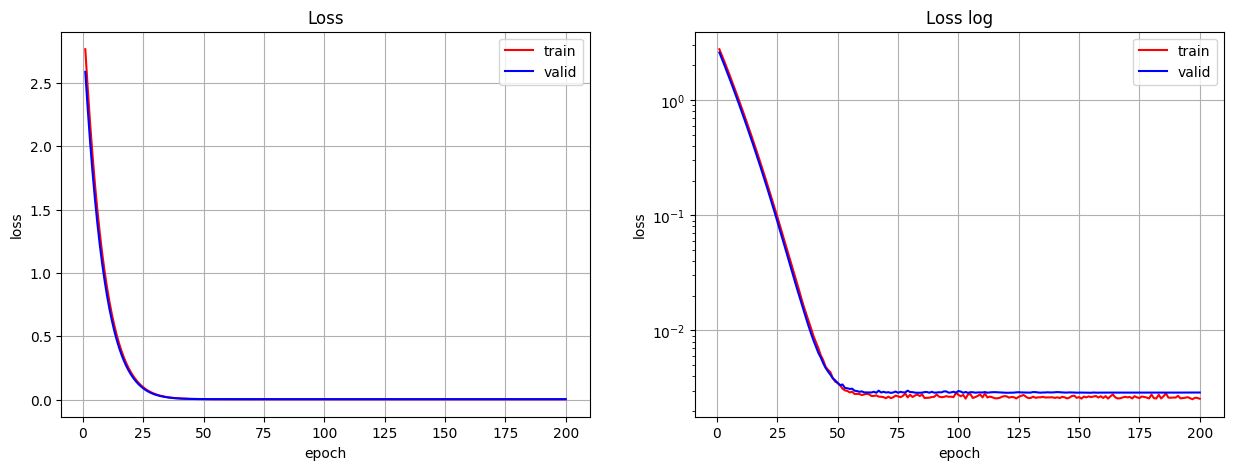

In [13]:
model_dnn_loose_constraints = Sequential((
    Flatten(input_shape=x_train.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train_loose_constraints.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_loose_constraints,
                         x_train, y_train_loose_constraints,
                         x_val, y_val_loose_constraints,
                         x_test, y_test_loose_constraints)

## Backtesting

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


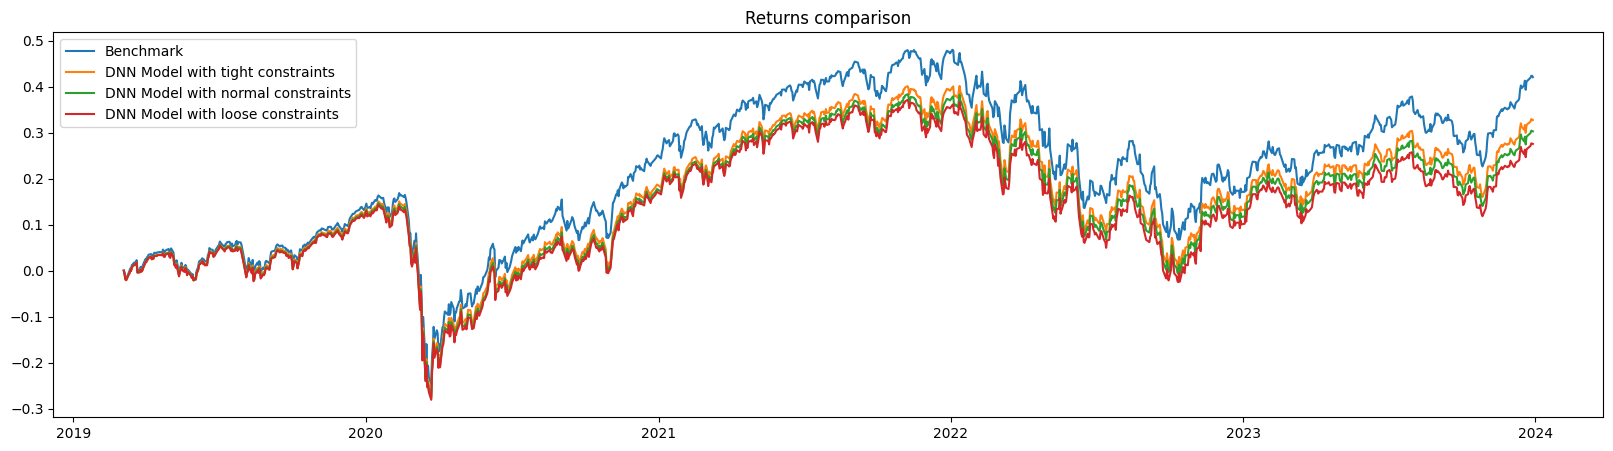

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
DNN Model with tight constraints,0.06119,0.200768,0.304777,0.352649,-0.367115,493.0,0.166677,-0.601255
DNN Model with normal constraints,0.057076,0.200326,0.284916,0.32854,-0.369684,538.0,0.154392,-0.683189
DNN Model with loose constraints,0.052443,0.199252,0.263199,0.303322,-0.370515,538.0,0.141541,-0.738747


In [22]:
from helper_functions import run_full_backtesting

models = {
    'DNN Model with tight constraints': model_dnn_tight_constraints,
    'DNN Model with normal constraints': model_dnn_normal_constraints,
    'DNN Model with loose constraints': model_dnn_loose_constraints
}

df_results = run_full_backtesting(data_provider, x_test, models)
df_results